# Lecture 2 - Generalized Linear Models: Model Selection and Multinomial Logistic Regression

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Perform likelihood-based model selection through analysis of deviance, Akaike Information Criterion, and Bayesian Information Criterion.
- Extend the link function concept of the generalized linear models (GLMs) to other discrete categorical responses.
- Outline the modelling framework of the Multinomial Logistic regression.
- Fit and interpret the Multinomial Logistic regression.
- Use the Multinomial Logistic regression for prediction.

## Loading Libraries

In [1]:
options(repr.matrix.max.rows = 7)
library(tidyverse)
library(broom)
library(glmbb)
library(AER)
library(bayesrules)
library(cowplot)
library(janitor)
library(nnet)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following

## 1. Likelihood-based Model Selection

In **DSCI 561**, you learned about **model selection** in Ordinary Least-Squares (OLS) via specific metrics such as the Mallow’s $C_p$, Akaike information criterion (AIC), and Bayesian information criterion (BIC). These metrics are also helpful tools to perform **model selection** in GLMs. Additionally, it is essential to highlight that **many** GLMs are estimated via maximum likelihood.

Having said all this, you will learn today that metrics such as AIC and BIC are likelihood-based. Hence, the concept of maximum likelihood estimation (MLE) will come into play again for model selection **in many GLMs**. Firstly, let us explore model selection for Poisson regression via the dataset from {doc}`lecture1-glm-link-functions-and-count-regression`.

### 1.1. The Crabs Dataset

``` {figure} ../img/crab.png
:height: 350px
Hello! I'm the Crab, again!
```

The data frame `crabs` ([Brockmann, 1996](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1439-0310.1996.tb01099.x)) is a dataset detailing the **counts of satellite male crabs** residing around a female crab nest. The code below renames the original response's name, `satell`, to `n_males`.

In [2]:
data(crabs)
crabs <- crabs %>%
  rename(n_males = satell) %>%
  dplyr::select(-y)
crabs

color,spine,width,n_males,weight
<fct>,<fct>,<dbl>,<int>,<int>
medium,bad,28.3,8,3050
dark,bad,22.5,0,1550
light,good,26.0,9,2300
dark,bad,24.8,0,2100
⋮,⋮,⋮,⋮,⋮
light,good,28.0,0,2625
darker,bad,27.0,0,2625
medium,middle,24.5,0,2000


```{admonition} The Crabs Dataset
The data frame `crabs` contains 173 observations on horseshoe crabs (Limulus polyphemus). The response is the count of male crabs (`n_males`) around a female breeding nest. It is subject to four explanatory variables: `color` of the prosoma with four levels (nominal factor-type), the condition of the posterior `spine` with three levels (nominal factor-type), the continuous variables carapace `width` (mm), and `weight` (g).
```

### 1.2. Estimation

**To perform model selection**, let us estimate two Poisson regression models with `n_males` as a response. **Model 1** will only have the continuous carapace `width` ($X_{\texttt{width}_i}$) as a regressor, whereas **Model 2** will have carapace `width` ($X_{\texttt{width}_i}$) and `color` of the prosoma (with dummy variables $X_{\texttt{color_darker}_i}$, $X_{\texttt{color_light}_i}$, and $X_{\texttt{color_medium}_i}$).

```{math}
\begin{align*}
\textbf{Model 1:} & \\ 
& h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i}. \\
\textbf{Model 2:} & \\ 
& h(\lambda_i) = \log (\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}.
\end{align*}
```

Then, via `glm()` and `crabs`, we obtain our regression estimates.

In [3]:
poisson_model <- glm(n_males ~ width, family = poisson, data = crabs)
poisson_model_2 <- glm(n_males ~ width + color, family = poisson, data = crabs)

Since we are digging into model selection, let us keep in mind the below **main statistical inquiry**.

```{admonition} Main statistical inquiry
We want to determine which Poisson regression model fits the data better: **Model 1** or **Model 2**.
```

### 1.3.  Goodness of Fit Test

The **deviance** ($D_k$) criterion can be used to compare a given model with $k$ regressors with that of a **baseline model**.

```{admonition} Definition of a Saturated or Full Model in Poisson Regression
:class: tip
The usual **baseline model** is the **saturated** or **full model**, which perfectly fits the data because it allows a distinct Poisson mean $\lambda_i$ for the $i$th observation in the training dataset ($i = 1, \dots, n$), **unrelated to the $k$ regressors**.
```

The **maximized likelihood** of this full model is denoted as $\hat{\mathscr{l}}_f$. Now, let $\hat{\mathscr{l}}_k$ be the value of the maximized likelihood computed from our dataset of $n$ observations with $k$ regressors.

We can compare the fits provided by these two models by the deviance $D_k$ given by

```{math}
:label: deviance-general
D_k = -2 \log \left( \frac{\hat{\mathscr{l}}_k}{\hat{\mathscr{l}}_f} \right) =  -2 \left[ \log \left( \hat{\mathscr{l}}_k \right) - \log \left( \hat{\mathscr{l}}_f \right) \right].
```

Note that $D_k$ expresses **how much our given model deviates from the full model on log-likelihood scale**. This metric is interpreted as follows:

- **Large values** of $D_k$ arise when $\hat{\mathscr{l}}_k$ is small relative to $\hat{\mathscr{l}}_f$, indicating that **our given model fits the data poorly compared to the baseline model**.
- **Small values** of $D_k$ arise when $\hat{\mathscr{l}}_k$ is similar to $\hat{\mathscr{l}}_f$, indicating that **our given model provides a good fit to the data compared to the baseline model**.

**Specifically for Poisson regression with $k$ regressors**, it can be shown that $D_k$ {eq}`deviance-general` is defined as follows:

```{math}
:label: deviance-poisson
\begin{gather}
\hat{\lambda}_i = \exp{\left( \hat{\beta_0} + \hat{\beta}_1 x_{i,1} + \dots + \hat{\beta}_k x_{i,k} \right)} \\
D_k = 2 \sum_{i = 1}^n \left[ y_i \log \left( \frac{y_i}{\hat{\lambda}_i} \right) - \left( y_i - \hat{\lambda}_i \right) \right]
\end{gather}
```

where $y_i$ is the $i$th observed response in the training set of size $n$. Note that when $y_i = 0$ counts, then $\log \left( \frac{y_i}{\hat{\lambda}_i} \right)$ is assumed as $0$.

````{admonition} Definition of Goodness of Fit
:class: tip
Equation {eq}`deviance-poisson` depicts the agreement of our model with $k$ regressors to the observed data. Hence, we can use {eq}`deviance-poisson` to test the goodness of fit; i.e., **whether our fitted model fits the data better than the saturated model, which makes it correctly specified (with a level of significance $\alpha$!)**.

The hypothesis are the following:

```{math}
\begin{gather*}
H_0: \text{Our}\textbf{ Model with $k$ regressors} \text{ fits the data better than the } \textbf{Saturated Model} \\
H_a: \text{otherwise.}
\end{gather*}
```
````

Let us test our `poisson_model_2`:

$$h(\lambda_i) = \log (\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}.$$

We cannot use `anova()` to perform this hypothesis testing. We will have to do it manually via `glance()`,

In [4]:
summary_poisson_model_2 <- glance(poisson_model_2)
summary_poisson_model_2

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
632.7917,172,-457.3212,924.6425,940.4089,559.3448,168,173


Column `deviance` provides $D_k$ and is formally called **residual deviance**, which is the **test statistic**. **Asymptotically**, we have the following **null distribution**:

$$
D_k \sim \chi^2_{n - (k + 1)}.
$$

The degrees of freedom (column `df.residual` in our `glance()` output) are the **difference between the training set size $n$ and the number of regression parameters in our model (including the intercept $\beta_0$).**

Let us obtain the corresponding $p\text{-value}$ for this test. We can do it using `pchisq()`:

In [5]:
pchisq(summary_poisson_model_2$deviance,
  df = summary_poisson_model_2$df.residual,
  lower.tail = FALSE
)

[1] 1.471037e-43

We obtain a $p\text{-value} < .001$, which gives statistical evidence to state that our `poisson_model_2` is **not** correctly specified when compared to the saturated model.

#### A Note on the Null Deviance

The above `glance()` output contains a metric call `null.deviance`. This metric comes from a Poisson regression model which is only estimated with an intercept, i.e., $\hat{\beta}_{0}$; let us call it $D_0$:

```{math}
\begin{gather}
\hat{\lambda}_i = \exp{\left( \hat{\beta_0} \right)} \\
D_0 = 2 \sum_{i = 1}^n \left[ y_i \log \left( \frac{y_i}{\hat{\lambda}_i} \right) - \left( y_i - \hat{\lambda}_i \right) \right]
\end{gather}
```

where $y_i$ is the $i$th observed response in the training set of size $n$. Note that when $y_i = 0$ counts, then $\log \left( \frac{y_i}{\hat{\lambda}_i} \right)$ is assumed as $0$.

Moreover, `df.null` indicates the degrees of freedom of this model, which are $n - 1 = 173 - 1 = 172$ (**the difference between the training set size $n$ and the number of regression parameters in the null model**; which is $1$ in this case, i.e., $\beta_0$).

```{important} 
A null model is different from a **saturated/baseline/full model**. It is importat to recall that the **saturated/baseline/full model** is a model that perfectly fits the training data, which could be viewed as basically interpolating all the training data points **without caring about any regressor at all**. Mathematically, the saturated model implicates having an exact prediction $\hat{\lambda}_i$ for each $y_i$:

$$\hat{\lambda}_i = y_i \text{ for } i = 1, \dots, n.$$
```

### 1.4. Analysis of Deviance for Nested Models

We can use analysis of deviance for model selection when two models are nested. Hence, we will test our two Poisson models:

```{math}
\begin{align*}
\textbf{Model 1:} & \\ 
& h(\lambda_i) = \log(\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i}. \\
\textbf{Model 2:} & \\ 
& h(\lambda_i) = \log (\lambda_i) = \beta_0 + \beta_1 X_{\texttt{width}_i} + \beta_2 X_{\texttt{color_darker}_i} + \beta_3 X_{\texttt{color_light}_i} + \beta_4 X_{\texttt{color_medium}_i}.
\end{align*}
```

This specific model selection will involve a hypothesis testing. The hypotheses are:

```{math}
\begin{gather*}
H_0: \textbf{Model 1} \text{ fits the data better than } \textbf{Model 2} \\
H_a: \textbf{Model 2} \text{ fits the data better than } \textbf{Model 1}.
\end{gather*}
```

We have to use the multipurpose function `anova()` in the following way:

In [6]:
round(anova(poisson_model,
  poisson_model_2,
  test = "Chi"
), 4)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,171,567.8786,NA,NA,NA
2,168,559.3448,3,8.5338,0.0362


Let $D_2$ be the deviance (column `Resid. Dev`) for **Model 2** (`poisson_model_2`) in row 2 and $D_1$ (column `Resid. Dev`) the deviance for **Model 1** (`poisson_model`) in row 1. The **test statistic** $\Delta_D$ (column `Deviance`) for the analysis of deviance is given by:

$$
\Delta_D = D_1 - D_2 \sim \chi^2_{3},
$$

which **asymptotically** (i.e., $n \rightarrow \infty$) is [**Chi-squared distributed**](https://www.math.wm.edu/~leemis/chart/UDR/PDFs/Chisquare.pdf) with $3$ degrees of freedom (column `Df`) under $H_0$ **for this specific case**.

We obtain a $p\text{-value} < .05$, column `Pr(>Chi)`, which gives us evidence to reject $H_0$ with $\alpha = 0.05$. Hence, we do have evidence to conclude that `poisson_model_2` fits the data better than `poisson_model`. Therefore, **in the context of model selection**, we would choose `poisson_model_2`, that also includes the `color` of the prosoma.

```{important} 
In general, the degrees of freedom are the **regression parameters of difference between both models** (this has an impact on the factor-type explanatory variables with more than one dummy variable). In this example, **Model 2** has three additional parameters: $\beta_2$, $\beta_3$, and $\beta_4$.

Formally, this nested hypothesis testing is called the **likelihood-ratio test**.
```

### 1.5. Akaike Information Criterion

**One of the drawbacks of the analysis of deviance** is that it only allows to test **nested** regression models. Fortunately, we have alternatives for model selection. **The AIC makes possible to compare models that are either nested or not.** For a model with $k$ model terms and a deviance $D_k$ is defined as:

```{math}
\begin{equation}
\mbox{AIC}_k = D_k + 2k.
\end{equation}
```

Models with **smaller** values of $\mbox{AIC}_k$ are preferred. That said, $\mbox{AIC}_k$ favours models with small values of $D_k$.

```{important}
However, $\mbox{AIC}_k$ penalizes for including more regressors in the model. Hence, it discourages overfitting, which is key in model selection. 

This is why we select that model with the smallest $\mbox{AIC}_k$.
```

The function `glance()` shows us the $\mbox{AIC}_k$ by model.

In [7]:
glance(poisson_model) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
632.792,172,-461.588,927.176,933.483,567.879,171,173


In [8]:
glance(poisson_model_2) %>% mutate_if(is.numeric, round, 3)

null.deviance,df.null,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
632.792,172,-457.321,924.642,940.409,559.345,168,173


> Following the results of the `AIC` column, we choose `poisson_model_2` over `poisson_model`.

### 1.6. Bayesian Information Criterion

An alternative to AIC is the Bayesian Information Criterion (BIC). **The BIC also makes possible to compare models that are either nested or not.** For a model with $k$ regressors, $n$ observations used for training, and a deviance $D_k$; it is defined as:

```{math}
\mbox{BIC}_k = D_k + k \log (n).
```

Models with **smaller** values of $\mbox{BIC}_k$ are preferred. That said, $\mbox{BIC}_k$ also favours models with small values of $D_k$.

```{important}
The differences between AIC and BIC will be more pronounced in datasets with large sample sizes $n$. As the BIC penalty of $k \log (n)$ will always be larger than the AIC penalty of $2k$ when $n > 7$, **BIC tends to select models with fewer regressors than AIC**.
```

> Following the results of the `AIC` column, we already chose `poisson_model_2` over `poisson_model`. Nonetheless, the `BIC` is penalizing the `poisson_model_2` for having more model parameters, so `poisson_model` would be chosen under this criterion.

## 2. Categorical Type Responses

So far, we have dealt with continuous, binary, and count responses using OLS, Binary Logistic, Poisson (or Negative Binomial) regressions, respectively.

Nonetheless, we have not covered those **discrete responses with more than two categories**. Recall that the nature of these responses could be:

- **Nominal.** We have categories that do not follow any specific order—for example, the type of dwelling according to the Canadian census: *single-detached house*, *semi-detached house*, *row house*, *apartment*, and *mobile home*.
- **Ordinal.** The categories, in this case, follow a specific order—for example, a Likert scale of survey items: *strongly disagree*, *disagree*, *neutral*, *agree*, and *strongly agree*.

Moreover, you have seen in **DSCI 561** that **using OLS to fit a model with a binary response variable has important problems**. Frequently, the restricted range is not respected in terms of the fitted values from our training set or if we use the fitted model to make predictions on a different testing set. So then, we use Binary Logistic regression.

```{important}
Recall that Binary Logistic regression's link function (the **logarithm of the odds** or **logit function**) restricts the corresponding probability of success to a range between $0$ and $1$ while relating it to the systematic component (i.e., the regressors and its corresponding parameters!). 

Nevertheless, this GLM has an important limitation: it is restricted to a Bernoulli trial with only two classes (**success** or **failure**).
```

Then, we might wonder: **what if we have more than two classes in the categorical response?** 

Let us pave the way to two new GLMs to address this matter: **Multinomial and Ordinal Logistic regressions**.

## 3. Multinomial Logistic Regression

Moving along with GLMs, let us expand the regression mind map as in {numref}`reg-mindmap-3` to include a new model: **Multinomial Logistic regression**.

````{div} full-width
```{figure} ../img/reg-mindmap-3.png
:height: 1000px
:name: reg-mindmap-3
Expanded regression modelling mind map.
```
````

**Multinomial Logistic regression** is a maximum likelihood-based GLM that addresses inferential (and predictive!) inquiries where the response is **categorical** and **nominal**. To illustrate the use of this GLM, let us introduce an adequate dataset.

### 3.1. The Spotify® Dataset

> *Copyright © 2024 Spotify AB.*
>
> *Spotify is a registered trademark of the Spotify Group.*

The `spotify` dataset is a sample of $n = 350$ songs with different variables by column. 

```{admonition} The Spotify Dataset
This data comes in the `bayesrules` package. Its description is the following:

> *A sub-sample of the Spotify® song data originally collected by Kaylin Pavlik (kaylinquest) and distributed through the `R` for Data Science TidyTuesday project.*
```

This dataset has 23 variables in total. The $n = 350$ songs belong to 44 different artists.

In [9]:
spotify

track_id,title,artist,popularity,album_id,album_name,album_release_date,playlist_name,playlist_id,genre,⋯,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7sYAS4CpbV90oSemgaEQat,On & On,Alok,79,2a9AGivapFES2j2ElI3odn,On & On,2019-11-22,Dance Room,37i9dQZF1DX2ENAPP1Tyed,pop,⋯,10,-5.898,0,7.22,2.330,0.00138,76.10,67.0,125.070,147027
1YSwQvw1NrEPfA0j1iY8eV,All The Lies,Alok,56,2FdyKqNeEX2H7gUhtlmJDC,All The Lies (Remixes),2019-07-19,Cardio,37i9dQZF1DWSJHnPb1f0X3,pop,⋯,6,-4.777,1,17.50,0.908,0.00000,36.60,63.4,119.972,163000
39cmB3ZoTOLwOTq7tMNqKa,Hear Me Now,Alok,75,6fpsA5aYbVNLe6y3P49o2o,Hear Me Now,2016,ElectroPop 2020,4frhr6RQM2fMOm2mpvOVo6,pop,⋯,11,-7.603,1,3.89,54.600,0.28900,7.31,49.6,121.999,194840
2Dnb6yPGUq0vmGtxzm3bwi,The Wall,Alok,65,0hH9tb1b4Z87g7SHmnriKa,The Wall,2019-06-28,Electropop,2Z5cPJ6Z4EVZAfF08amjvL,pop,⋯,11,-2.314,1,4.31,0.953,6.73000,7.32,53.6,122.943,159500
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3SmytDq4CeZ3nKE9777qEx,Save My Grave,Zeds Dead,54,0M5oUKrfgJtfZUKdFsC4VZ,We Are Deadbeats (Vol. 4),2020-01-14,Trap Nation,0NCspsyf0OS4BsPgGhkQXM,rap,⋯,8,-8.101,0,3.15,1.47000,0.0733,15.8,12.3,108.021,222387
606LnHssjBNoQIrxa9KTYK,Shake,Zeds Dead,49,2S3ydN35socDKdH6ROBhfN,Shake,2019-09-10,Nasty Bits,37i9dQZF1DX2VvACCrgjrt,edm,⋯,8,-3.680,1,6.57,0.00178,32.4000,18.0,36.6,75.026,278400
4kbaxfwAF2FaquuDiWSkDT,Sound Of The Underground,Zeds Dead,48,4xjytv2hkFsqSz2z8y6efp,Sound Of The Underground,2019-12-04,ELECTRO HOUSE 2020,1N5dPU0Ca9N9AwBbUeyzX5,edm,⋯,1,-0.247,1,10.40,0.32300,75.8000,11.2,19.2,170.084,248480


We will start with an in-class question via [**iClicker**](https://student.iclicker.com/).

```{exercise}
:label: lecture2-q1

Having checked the description of the `spotify` dataset, suppose we want to conduct an inferential study. What would be the primary nature of our conclusions?

**A.** We could draw causation conclusions across all music platforms.

**B.** We could draw association conclusions on the Spotify® platform.

**C.** We could draw association conclusions across all music platforms.

**D.** We could draw causation conclusions on the Spotify® platform.
```

```{admonition} Main Statistical Inquiries
I am **big fan** of the electronic dance music (`edm`) catalogue on Spotify®. Nevertheless, I do not have access to their whole song database. Still, I want to do the following:

- To statistically measure how danceable this genre is, compared to other genres on the platform, and by how much.
- To statistically measure how euphoric this genre is, compared to other genres on the platform, and by how much.
```

### 3.2. Data Wrangling and Summary

In terms of our main statistical inquiries, we will extract these **key variables by song** from the `spotify` dataset:

- `genre`: genre of the playlist where the song belongs (a **categorical** and **nominal** variable).
- `danceability`:  a **numerical** score from 0 (not danceable) to 100 (danceable) based on features such as tempo, rhythm, etc.
- `valence`: a **numerical** score from 0 (the song is more negative, sad, angry) to 100 (the song is more positive, happy, **euphoric**).

We will also extract these secondary variables (**not to be used in our analysis**, just for having a more informative training data):

- `title`: song name.
- `artist`: song artist.
- `album_name`: name of the album on which the song appears.

In [10]:
spotify_training <- spotify %>%
  select(title, artist, album_name, genre, danceability, valence) %>%
  mutate(genre = as.factor(genre))
spotify_training

title,artist,album_name,genre,danceability,valence
<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>
On & On,Alok,On & On,pop,74.7,67.0
All The Lies,Alok,All The Lies (Remixes),pop,70.7,63.4
Hear Me Now,Alok,Hear Me Now,pop,77.8,49.6
The Wall,Alok,The Wall,pop,68.2,53.6
⋮,⋮,⋮,⋮,⋮,⋮
Save My Grave,Zeds Dead,We Are Deadbeats (Vol. 4),rap,60.4,12.3
Shake,Zeds Dead,Shake,edm,50.1,36.6
Sound Of The Underground,Zeds Dead,Sound Of The Underground,edm,67.5,19.2


```{important}
Note that factor-type `genre` has six levels (`edm` refers to **electronic dance music** and `r&b` to **rhythm and blues**). Moreover, **from a coding perspective**, `edm` is the **baseline** level (it is located on the **left-hand side** in the `levels()` output).
```

In [11]:
levels(spotify_training$genre)

[1] "edm"   "latin" "pop"   "r&b"   "rap"   "rock"

Finally, let us summarize the data by `genre`.

In [12]:
spotify_training %>% tabyl(genre) %>%
  adorn_totals("row") %>%
  adorn_pct_formatting()

,genre,n,percent
,<fct>,<dbl>,<chr>
1,edm,60,17.1%
2,latin,27,7.7%
3,pop,71,20.3%
4,r&b,104,29.7%
5,rap,62,17.7%
6,rock,26,7.4%
7,Total,350,100.0%


```{important}
Note that `edm` accounts for 17.1% of the whole training data. On the other hand, `latin` and `rock` account for less than 10% each. Finally, `r&b` has the largest share with 29.7%. 

Still, having checked this `genre` composition, we have an acceptable number of songs to draw inference from. Moreover, an imbalanced classification will be dealt with the distributional assumption of the Multinomial Logistic regression.
```

### 3.3. Exploratory Data Analysis

As done in our previous lecture, let us take a look at the data first. Note that `genre` is a **discrete nominal response**, so we must be careful about the class of plots we use for exploratory data analysis (EDA). Hence, we could use the following side-by-side plots for both `danceability` and `valence`:

- **Boxplots.**
- **Violin plots.**

The code below creates side-by-side boxplots and violin plots, where `danceability` or `valence` are on the $y$-axis, and all categories of `genre` are on the $x$-axis. Moreover, the side-by-side violin plots show the mean of `danceability` or `valence` by `genre` as orange points.

In [13]:
options(repr.plot.height = 18, repr.plot.width = 20)

genre_danceability_side_boxplots <- spotify_training %>%
  ggplot(aes(genre, danceability)) +
  geom_boxplot(aes(fill = genre)) +
  labs(y = "Danceability (0-100)", x = "Genre") +
  ggtitle("Side-by-Side Boxplots for Danceability") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21, angle = 10),
    axis.title = element_text(size = 27),
    legend.position = "none"
  ) +
  scale_fill_brewer(palette = "BuPu")

genre_danceability_side_violin <- spotify_training %>%
  ggplot(aes(genre, danceability)) +
  geom_violin(aes(fill = genre)) +
  labs(y = "Danceability (0-100)", x = "Genre") +
  ggtitle("Side-by-Side Violin Plots for Danceability") +
  stat_summary(
    fun = mean, colour = "orange", geom = "point",
    shape = 18, size = 5
  ) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21, angle = 10),
    axis.title = element_text(size = 27),
    legend.position = "none"
  ) +
  scale_fill_brewer(palette = "BuPu")

genre_valence_side_boxplots <- spotify_training %>%
  ggplot(aes(genre, valence)) +
  geom_boxplot(aes(fill = genre)) +
  labs(y = "Valence (0-100)", x = "Genre") +
  ggtitle("Side-by-Side Boxplots for Valence") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21, angle = 10),
    axis.title = element_text(size = 27),
    legend.position = "none"
  ) +
  scale_fill_brewer(palette = "BuPu")

genre_valence_side_violin <- spotify_training %>%
  ggplot(aes(genre, valence)) +
  geom_violin(aes(fill = genre)) +
  labs(y = "Valence (0-100)", x = "Genre") +
  ggtitle("Side-by-Side Violin Plots for Valence") +
  stat_summary(
    fun = mean, colour = "orange", geom = "point",
    shape = 18, size = 5
  ) +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21, angle = 10),
    axis.title = element_text(size = 27),
    legend.position = "none"
  ) +
  scale_fill_brewer(palette = "BuPu")

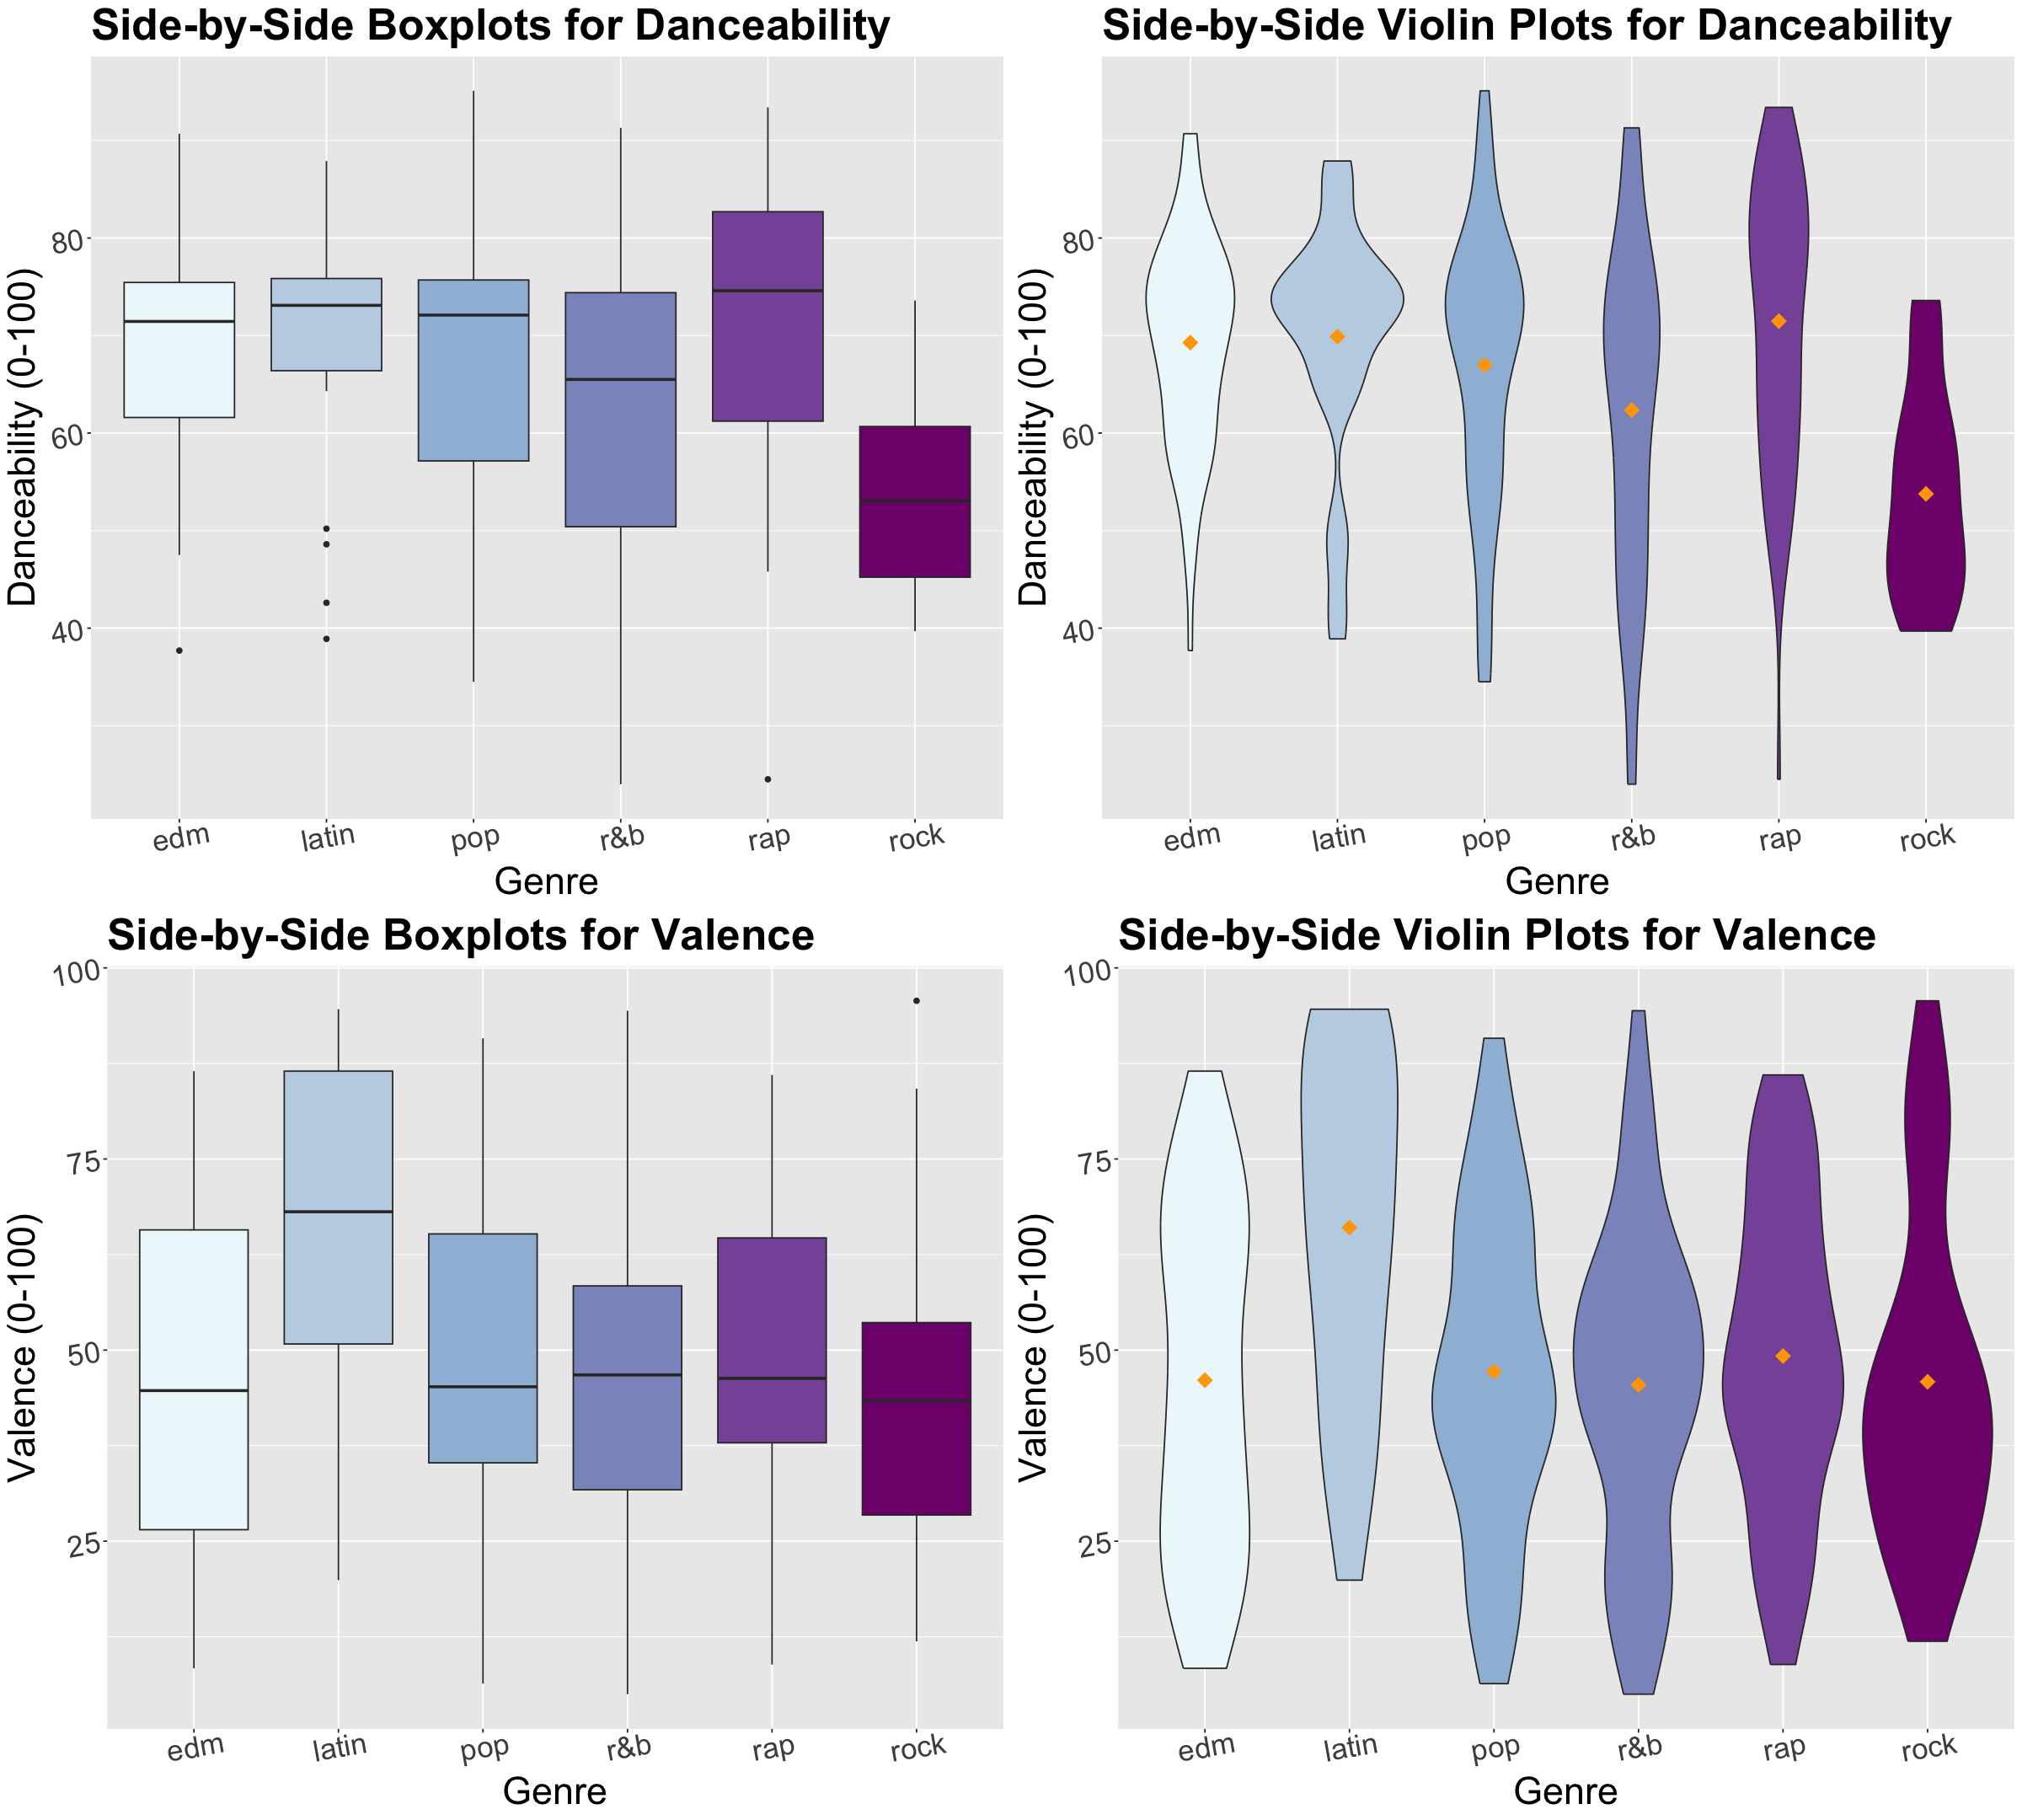

In [14]:
plot_grid(genre_danceability_side_boxplots, genre_danceability_side_violin, 
          genre_valence_side_boxplots, genre_valence_side_violin,
          nrow = 2)

```{exercise}
:label: lecture2-q2

What can we see **descriptively** from the above plots?
```

### 3.4. Data Modelling Framework

A **Multinomial Logistic Regression model** is a suitable approach to our statistical inquiries given that `genre` is **categorical** and **nominal** (our response of interest) subject to the **numerical** regressors `danceability` and `valence`. Moreover, its corresponding regression estimates will allow us **to measure variable association**.

#### 3.4.1. Primary Intuition of the Multinomial Logistic Regression Model

Digging into the Multinomial Logistic regression model will require checking **Binary Logistic regression** first. Hence, let us do it quickly. Thus, suppose we are initially interested in two genres: `edm` and `latin`.

In [15]:
bin_spotify_training <- spotify_training %>% 
  filter(genre %in% c("edm", "latin")) %>%
  mutate(genre = droplevels(genre))
bin_spotify_training

title,artist,album_name,genre,danceability,valence
<chr>,<fct>,<chr>,<fct>,<dbl>,<dbl>
Toda La Noche,Alok,Toda La Noche,latin,73.5,61.6
On & On,Alok,On & On,edm,74.7,67.0
The Wall,Alok,The Wall,edm,68.2,53.6
Tell Me Why,Alok,Tell Me Why,edm,56.1,19.5
⋮,⋮,⋮,⋮,⋮,⋮
Renegades - Stash Konig Remix,X Ambassadors,Renegades (Stash Konig Remix),edm,66.3,78.9
Shake,Zeds Dead,Shake,edm,50.1,36.6
Sound Of The Underground,Zeds Dead,Sound Of The Underground,edm,67.5,19.2


Note `edm` is the baseline level (i.e., it appears on the left-hand side in the `levels()` output).

In [16]:
levels(bin_spotify_training$genre)

[1] "edm"   "latin"

Assuming we have a **training set** of $n$ elements, recall that the $i$th response (for $i = 1, \dots, n$) in a **Binary Logistic regression** is 

$$Y_i =
\begin{cases}
1 \; \; \; \; \mbox{if the genre is } \texttt{latin},\\
0 \; \; \; \; \mbox{if the baseline genre is } \texttt{edm}.
\end{cases}
$$

Therefore

$$Y_i \sim \text{Bernoulli}(p_i),$$

whose probability of success is $p_i$.

In this model, we will use the following **link function** (where $X_{i,\texttt{dance}}$ anf $X_{i,\texttt{val}}$ are the `danceability` and `valence` scores for the $i$th song, respectively):

```{math}
\begin{align*}
\mbox{logit}(p_i) &= \log\left(\frac{p_i}{1 - p_i}\right) \nonumber \\
&= \log \left[ \frac{P(Y_i = \texttt{latin}\mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})}) \right] \nonumber \\
&= \beta_0 + \beta_1 X_{i,\texttt{dance}} + \beta_2 X_{i,\texttt{val}}.
\end{align*}
```

In plain words, the **natural logarithm** of the **odds** is equal to a **systematic component** containing the regressors $X_{i,\texttt{dance}}$ and $X_{i,\texttt{val}}$.

 Recall that this model can be fitted as follows:

In [17]:
spotify_bin_log_model <- glm(
  formula = genre ~ danceability + valence,
  data = bin_spotify_training,
  family = binomial
)

Note that only `valence` is statistically significant for the response `genre` ($p\text{-value} < .001$).

In [18]:
tidy(spotify_bin_log_model, conf.int = TRUE, exponentiate = TRUE) %>% mutate_if(is.numeric, round, 2)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.36,1.70,-0.60,0.55,0.01,8.91
danceability,0.97,0.03,-1.23,0.22,0.92,1.02
valence,1.05,0.01,3.47,0.00,1.02,1.08


Then, we make the corresponding coefficient interpretations (the previous output already provides the estimate on the odds scale via `exponentiate = TRUE`):

> For each unit increase in the `valence` score in the Spotify® catalogue, the song is 1.05 times more likely to be `latin` than `edm`.

#### 3.4.2.  More than One Logit Function

**What if our response is nominal and has more than two categories?** In that case, let us suppose that a given **discrete nominal response $Y_i$ has categories $1, 2, \dots, m$**.

```{important}
Categories $1, 2, \dots, m$ **are merely labels here**. Thus, they **do not** implicate an ordinal scale.
```

This regression approach assumes a [**Multinomial distribution**](https://www.sciencedirect.com/topics/mathematics/multinomial-distribution) where $p_{i,1}, p_{i,2}, \dots, p_{i,m}$ are the probabilities that $Y_i$ will belong to categories $1, 2, \dots, m$ respectively; i.e.,

$$
P(Y_i = 1) = p_{i,1} \;\;\;\; P(Y_i = 2) = p_{i,2} \;\; \dots \;\; P(Y_i = m) = p_{i,m},
$$

where

$$
\sum_{j = 1}^m p_{i,j} = p_{i,1} + p_{i,2} + \dots + p_{i,m} = 1.
$$

```{important}
A particular highlight is that the Binomial distribution is the special Multinomial case when $m = 2$.
```

The Multinomial Logistic regression **also models the logarithm of the odds**. However, only one logarithm of the odds (or **logit**) will not be enough anymore. Recall we can capture the odds between two categories with a single logit function. **What about adding some other ones?**

Here is what we can do:

1. Pick one of the categories to be the **baseline**. For example, the category "$1$".
2. For each of the **other** categories, we model the logarithm of the odds to the baseline category.

Now, **what is the math for the general case with $m$ response categories and $k$ regressors?** For the $i$th observation, we end up with a system of $m - 1$ link functions in the Multinomial Logistic regression model as follows:

```{math}
:label: multinomial-model
\begin{gather*}
\eta_i^{(2,1)} = \log\left[\frac{P(Y_i = 2\mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(2,1)} + \beta_1^{(2,1)} X_{i, 1} + \beta_2^{(2,1)} X_{i, 2} + \ldots + \beta_k^{(2,1)} X_{i, k} \\
\eta_i^{(3,1)} = \log\left[\frac{P(Y_i = 3\mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(3,1)} + \beta_1^{(3,1)} X_{i, 1} + \beta_2^{(3,1)} X_{i, 2} + \ldots + \beta_k^{(3,1)} X_{i, k} \\
\vdots \\
\eta_i^{(m,1)} = \log\left[\frac{P(Y_i = m\mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(m,1)} + \beta_1^{(m,1)} X_{i, 1} + \beta_2^{(m,1)} X_{i, 2} + \ldots + \beta_k^{(m,1)} X_{i, k}.
\end{gather*}
```

```{important}
Note that the superscript $(j, 1)$ in {eq}`multinomial-model` indicates that the equation is on level $j$ (for $j = 2, \dots, m$) with respect to level $1$. Furthermore, **the regression coefficients are different for each link function**.
```

With some algebraic manipulation, we can show that the probabilities $p_{i,1}, p_{i,2}, \dots, p_{i,m}$ of $Y_i$ belonging to categories $1, 2, \dots, m$ are:

```{math}
:label: prob-multinomial
\begin{gather*}
p_{i,1} = P(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,k}) = \frac{1}{1 + \sum_{j = 2}^m \exp \big( \eta_i^{(j,1)} \big)} \\
p_{i,2} = P(Y_i = 2 \mid X_{i,1}, \ldots, X_{i,k}) = \frac{\exp \big( \eta_i^{(2,1)} \big)}{1 + \sum_{j = 2}^m \exp \big( \eta_i^{(j,1)} \big)} \\
\vdots \\
p_{i,m} = P(Y_i = m \mid X_{i,1}, \ldots, X_{i,k}) = \frac{\exp \big( \eta_i^{(m,1)} \big)}{1 + \sum_{j = 2}^m \exp \big( \eta_i^{(j,1)} \big)}.
\end{gather*}
```

```{important}
If we sum all $m$ probabilities in {eq}`prob-multinomial`, the sum will be equal to $1$ for the $i$th observation. **This is particularly important when we want to use this model for making predictions in classification matters**.
```

Going back to our example, let us set the Multinomial Logistic regression model with `genre` as a response subject to `danceability` and `valence` as a continuous regressor. Level `edm` will be the baseline:

In [19]:
levels(spotify_training$genre)

[1] "edm"   "latin" "pop"   "r&b"   "rap"   "rock"

Specifically, this case will implicate a **system of $m - 1 = 6 - 1= 5$ regression equations** (where $X_{i,\texttt{dance}}$ anf $X_{i,\texttt{val}}$ are the `danceability` and `valence` scores for the $i$th song, respectively):

```{math}
:label: multinomial-model-spotify
\begin{align*}
\eta_i^{(\texttt{latin},\texttt{edm})} = \log\left[\frac{P(Y_i = \texttt{latin} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}\right] = \beta_0^{(\texttt{latin},\texttt{edm})} + \beta_1^{(\texttt{latin},\texttt{edm})} X_{i, \texttt{dance}} + \beta_2^{(\texttt{latin},\texttt{edm})} X_{i, \texttt{val}} \\
\eta_i^{(\texttt{pop},\texttt{edm})} = \log\left[\frac{P(Y_i = \texttt{pop} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}\right] = \beta_0^{(\texttt{pop},\texttt{edm})} + \beta_1^{(\texttt{pop},\texttt{edm})} X_{i, \texttt{dance}} + \beta_2^{(\texttt{pop},\texttt{edm})} X_{i, \texttt{val}} \\
\eta_i^{(\texttt{r&b},\texttt{edm})} = \log\left[\frac{P(Y_i = \texttt{r&b} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}\right] = \beta_0^{(\texttt{r&b},\texttt{edm})} + \beta_1^{(\texttt{r&b},\texttt{edm})} X_{i, \texttt{dance}} + \beta_2^{(\texttt{r&b},\texttt{edm})} X_{i, \texttt{val}} \\
\eta_i^{(\texttt{rap},\texttt{edm})} = \log\left[\frac{P(Y_i = \texttt{rap} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}\right] = \beta_0^{(\texttt{rap},\texttt{edm})} + \beta_1^{(\texttt{rap},\texttt{edm})} X_{i, \texttt{dance}} + \beta_2^{(\texttt{rap},\texttt{edm})} X_{i, \texttt{val}} \\
\eta_i^{(\texttt{rock},\texttt{edm})} = \log\left[\frac{P(Y_i = \texttt{rock} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i, \texttt{dance}}, X_{i, \texttt{val}})}\right] = \beta_0^{(\texttt{rock},\texttt{edm})} + \beta_1^{(\texttt{rock},\texttt{edm})} X_{i, \texttt{dance}} + \beta_2^{(\texttt{rock},\texttt{edm})} X_{i, \texttt{val}}.
\end{align*}
```

```{important} 
In a Multinomial Logistic regression model, each link function has its own intercept and regression coefficients.
```

The modelling system of 5 logit functions {eq}`multinomial-model-spotify` can also be mathematically represented as follows (which might be helpful for our subsequent coefficient interpretation:

```{math}
:label: multinomial-model-spotify-2
\begin{gather*}
\frac{P(Y_i = \texttt{latin}\mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})} = \exp\left[\beta_0^{(\texttt{latin},\texttt{edm})}\right] \exp\left[\beta_1^{(\texttt{latin},\texttt{edm})} X_{i,\texttt{dance}}\right] \exp\left[\beta_2^{(\texttt{latin},\texttt{edm})} X_{i,\texttt{val}}\right] \\
\frac{P(Y_i = \texttt{pop}\mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})} = \exp\left[\beta_0^{(\texttt{pop},\texttt{edm})}\right] \exp\left[\beta_1^{(\texttt{pop},\texttt{edm})} X_{i,\texttt{dance}}\right] \exp\left[\beta_2^{(\texttt{pop},\texttt{edm})} X_{i,\texttt{val}}\right] \\
\frac{P(Y_i = \texttt{r&b}\mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})} = \exp\left[\beta_0^{(\texttt{r&b},\texttt{edm})}\right] \exp\left[\beta_1^{(\texttt{r&b},\texttt{edm})} X_{i,\texttt{dance}}\right] \exp\left[\beta_2^{(\texttt{r&b},\texttt{edm})} X_{i,\texttt{val}}\right]\\
\frac{P(Y_i = \texttt{rap}\mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})} = \exp\left[\beta_0^{(\texttt{rap},\texttt{edm})}\right] \exp\left[\beta_1^{(\texttt{rap},\texttt{edm})} X_{i,\texttt{dance}}\right] \exp\left[\beta_2^{(\texttt{rap},\texttt{edm})} X_{i,\texttt{val}}\right]\\
\frac{P(Y_i = \texttt{rock}\mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})}{P(Y_i = \texttt{edm} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}})} = \exp\left[\beta_0^{(\texttt{rock},\texttt{edm})}\right] \exp\left[\beta_1^{(\texttt{rock},\texttt{edm})} X_{i,\texttt{dance}}\right]
\exp\left[\beta_2^{(\texttt{rock},\texttt{edm})} X_{i,\texttt{val}}\right].
\end{gather*}
```

Finally, the probabilities of $Y_i$ belonging to categories `edm`, `latin`, `pop`, `r&b`, `rap`, and `rock` are:

```{math}
\begin{gather*}
p_{i,\texttt{edm}} = P(Y_i = \texttt{edm} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}}) = \frac{1}{1 + \exp\big(\eta_i^{(\texttt{latin},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{pop},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{r&b},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rap},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rock},\texttt{edm})}\big)} \\
p_{i,\texttt{latin}} = P(Y_i = \texttt{latin} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}}) = \frac{\exp\big(\eta_i^{(\texttt{latin},\texttt{edm})}\big)}{1 + \exp\big(\eta_i^{(\texttt{latin},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{pop},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{r&b},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rap},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rock},\texttt{edm})}\big)}\\
p_{i,\texttt{pop}} = P(Y_i = \texttt{pop} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}}) = \frac{\exp\big(\eta_i^{(\texttt{pop},\texttt{edm})}\big)}{1 + \exp\big(\eta_i^{(\texttt{latin},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{pop},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{r&b},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rap},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rock},\texttt{edm})}\big)} \\
p_{i,\texttt{r&b}} = P(Y_i = \texttt{r&b} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}}) = \frac{\exp\big(\eta_i^{(\texttt{r&b},\texttt{edm})}\big)}{1 + \exp\big(\eta_i^{(\texttt{latin},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{pop},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{r&b},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rap},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rock},\texttt{edm})}\big)} \\
p_{i,\texttt{rap}} = P(Y_i = \texttt{rap} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}}) = \frac{\exp\big(\eta_i^{(\texttt{rap},\texttt{edm})}\big)}{1 + \exp\big(\eta_i^{(\texttt{latin},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{pop},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{r&b},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rap},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rock},\texttt{edm})}\big)} \\
p_{i,\texttt{rock}} = P(Y_i = \texttt{rock} \mid X_{i,\texttt{dance}}, X_{i,\texttt{val}}) = \frac{\exp\big(\eta_i^{(\texttt{rock},\texttt{edm})}\big)}{1 + \exp\big(\eta_i^{(\texttt{latin},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{pop},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{r&b},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rap},\texttt{edm})}\big) + \exp\big(\eta_i^{(\texttt{rock},\texttt{edm})}\big)}.
\end{gather*}
```

Now, let us discuss some in-class questions:

```{exercise}
:label: lecture2-q3

Answer **TRUE** or **FALSE**:

Now that we removed the restriction of only one link function, we also removed the distributional assumption for $Y_i$. Hence, our model has no distributional assumption.

**A.** TRUE

**B.** FALSE
```

```{exercise}
:label: lecture2-q4

Answer **TRUE** or **FALSE**:

From the statistical point of view, the model is now non-parametric.

**A.** TRUE

**B.** FALSE
```

```{exercise}
:label: lecture2-q5

Suppose that, given our inquiries, a peer suggests we fit two separate OLS with `genre` as a regressor and `danceability` **OR** `valence` as the responses. Can you think of some drawbacks of this suggested approach?
```

### 3.5. Estimation

**All parameters** in the Multinomial Logistic regression model are also unknown. To fit the model with the package `nnet`, we use the function `multinom()`, which obtains the corresponding estimates. The estimates are obtained through **maximum likelihood**, where we assume a **Multinomial joint probability mass function** of the $n$ responses $Y_i$.

```{admonition} Note
:class: warning
We will not dig into mathematical derivations regarding MLE for this model since it would require digging into matrix notation, which is out of this course's scope. That said, you can find more information on this matter [**here**](https://czep.net/stat/mlelr.pdf).
```

In [20]:
spotify_mult_log_model <- multinom(
  formula = genre ~ danceability + valence,
  data = spotify_training
)

# weights:  24 (15 variable)
initial  value 627.115814 
iter  10 value 582.728217
iter  20 value 559.441415
final  value 559.441352 
converged


### 3.6. Inference

**We can determine whether a regressor is statistically associated with the logarithm of the odds** through hypothesis testing for the parameters $\beta_j^{(u, v)}$ **by link function**. We also use the **Wald statistic** $z_j^{(u, v)}$:

```{math}
\begin{equation*}
z_j^{(u, v)} = \frac{\hat{\beta}_j^{(u, v)}}{\mbox{se}\left(\hat{\beta}_j^{(u, v)}\right)}
\end{equation*}
```

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j^{(u, v)} = 0\\
H_a: \beta_j^{(u, v)} \neq 0.
\end{gather*}
```

Provided the sample size $n$ is large enough, $z_j$ has an **approximately Standard Normal distribution** under $H_0$.

`R` provides the corresponding **$p$-values** for each $\beta_j^{(u, v)}$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. As in the previous regression models, we would set a predetermined significance level $\alpha$ (usually taken to be 0.05) to infer if the $p$-value is small enough. If the $p$-value is smaller than the predetermined level $\alpha$, then you could claim that there is evidence to reject the null hypothesis. Hence, $p$-values that are small enough indicate that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the response variable and the $j$th regressor.

Furthermore, given a specified level of confidence where $\alpha$ is the significance level, we can construct approximate $(1 - \alpha) \times 100\%$ **confidence intervals** for the corresponding true value of $\beta_j^{(u, v)}$:

```{math}
\begin{equation*}
\hat{\beta}_j^{(u, v)} \pm z_{\alpha/2}\mbox{se} \left( \hat{\beta}_j^{(u, v)} \right),
\end{equation*}
```

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the **Standard Normal distribution**.

We can also use the function `tidy()` from the `broom` package along with argument `conf.int = TRUE` to get the 95% confidence intervals **by default**.

In [21]:
options(repr.matrix.max.rows = 15)

mult_output <- tidy(spotify_mult_log_model,
  conf.int = TRUE, exponentiate = TRUE
) %>%
  mutate_if(is.numeric, round, 3)
mult_output

y.level,term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
latin,(Intercept),0.101,1.419,-1.617,0.106,0.006,1.628
latin,danceability,0.981,0.020,-0.976,0.329,0.943,1.020
latin,valence,1.052,0.013,4.007,0.000,1.026,1.079
pop,(Intercept),2.492,0.893,1.023,0.306,0.433,14.337
pop,danceability,0.985,0.013,-1.112,0.266,0.959,1.011
pop,valence,1.006,0.009,0.661,0.508,0.988,1.024
r&b,(Intercept),14.547,0.811,3.302,0.001,2.969,71.274
r&b,danceability,0.963,0.013,-3.016,0.003,0.939,0.987
r&b,valence,1.008,0.008,0.973,0.331,0.992,1.025


The 15 exponentiated estimated regression parameters (via `exponentiate = TRUE` in `tidy()`) from the right-hand side of {eq}`multinomial-model-spotify-2` appear in the column `estimate.` Note that column `y.level` is related to the **non-baseline** level per function. Finally, to draw our inferential conclusions, let us filter those $p$-values less than $0.05$ from `mult_output`:

In [22]:
mult_output %>%
  dplyr::filter(p.value < 0.05)

y.level,term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
latin,valence,1.052,0.013,4.007,0.000,1.026,1.079
r&b,(Intercept),14.547,0.811,3.302,0.001,2.969,71.274
r&b,danceability,0.963,0.013,-3.016,0.003,0.939,0.987
rock,(Intercept),27.651,1.037,3.202,0.001,3.624,210.986
rock,danceability,0.918,0.019,-4.508,0.000,0.885,0.953


Since our baseline response is `edm`, we can conclude the following with $\alpha = 0.05$ **on the Spotify® platform**:

- There is a statistical difference in `danceability` in `edm` versus `r&b` and `rock`.
- There is a statistical difference in `valence` in `edm` versus `latin`.

### 3.7. Coefficient Interpretation

Interpretation of the Multinomial Logistic regression coefficients is **quite similar** to the Binary Logistic regression. Let us interpret those significant regression coefficientes from column `estimate`:

> $\beta_2^{(\texttt{latin},\texttt{edm})}$: for each unit increase in the `valence` score in the Spotify® catalogue, the song is $1.052$ times more likely to be `latin` than `edm`.

> $\beta_1^{(\texttt{r&b},\texttt{edm})}$: for each unit increase in the `danceability` score in the Spotify® catalogue, the odds for a song for being `r&b` decrease by $(1 - 0.963) \times 100\% = 3.7\%$ compared to `edm`.

> $\beta_1^{(\texttt{ock},\texttt{edm})}$: for each unit increase in the `danceability` score in the Spotify® catalogue, the odds for a song for being `rock` decrease by $(1 - 0.918) \times 100\% = 8.2\%$ compared to `edm`.

```{important} 
If we want to use another `genre` as a baseline under this modelling approach, we would need to relevel our factor-type response and rerun the whole process.

Also, this example does not include categorical regressors. Nevertheless, interpreting their corresponding estimated regression coefficients is analogous to [**Binary Logistic regression**] using the baseline response level.
```

### 3.8. Predictions

Suppose we want to predict the genre probabilities for a given song with a `danceability` score of `27.5` and `valence` of `30`. We could use the model `spotify_mult_log_model` for making such prediction as follows:

In [23]:
pred_probs <- round(predict(spotify_mult_log_model, tibble(danceability = 27.5, valence = 30), type = "probs"), 2)
pred_probs

edm latin   pop   r&b   rap  rock 
 0.06  0.02  0.12  0.41  0.04  0.34

In [24]:
sum(pred_probs) # Due to rounding, sum is 0.99 and not 1.

[1] 0.99

Note we have to use `type = "probs"` in the function `predict()` to obtain these predictions. Therefore, this given song has more chances of being `r&b`.

### 3.9. Model Selection

**To perform model selection**, we can use the same techniques from the Binary Logistic regression model (check {ref}`bin-log-model-selection`). That said, some `R` coding functions might not be entirely available for the `multinom()` models. Still, these statistical techniques and metrics can be manually coded.